# Mixed Calibration of model parameters: NVDA
### European puts and otko daily cliquet options

In [1]:
import numpy as np
import pandas as pd
from datetime import datetime
import matplotlib.pyplot as plt
import scipy.stats as ss
import scipy.optimize as scpo
import sys
sys.path.append('C:/Users\ornel\OneDrive\Desktop\TESI\PythonProjects\Margin-Loans-Pricing\python-modules/functions')
sys.path.append('C:/Users\ornel\OneDrive\Desktop\TESI\PythonProjects\Margin-Loans-Pricing\python-modules/calibration')
import time

from BSpricer import BS_Pricer
from MERTONpricer import Merton_pricer
from KOUpricer import Kou_pricer
from VGpricer import VG_pricer

mixed

In [3]:
puts_aapl = pd.read_csv('../../data/AAPL/OPT16_AAPL_PUTS_50_150.csv')
moneyness = [0.72, 0.88, 0.98, 1.01, 1.14, 1.29]
cond = puts_aapl['MONEYNESS'].isin(moneyness)
puts = puts_aapl[cond].copy()
puts.reset_index(drop=True, inplace=True)
print(puts)

   QUOTE_DATE  UNDERLYING_LAST EXPIRE_DATE  P_BID  P_ASK  STRIKE     P_IV   
0  2016-01-20            96.79  2017-01-20   3.30   3.40    70.0  0.37716  \
1  2016-01-20            96.79  2017-01-20   7.50   7.65    85.0  0.34912   
2  2016-01-20            96.79  2017-01-20  11.90  12.04    95.0  0.33684   
3  2016-01-20            96.79  2017-01-20  13.15  13.36    97.5  0.33399   
4  2016-01-20            96.79  2017-01-20  20.75  20.99   110.0  0.32280   
5  2016-01-20            96.79  2017-01-20  32.06  32.40   125.0  0.31712   

   MONEYNESS  
0       0.72  
1       0.88  
2       0.98  
3       1.01  
4       1.14  
5       1.29  


Let's initialize the values for our calibration.

In [5]:
puts['P_Midpoint'] = abs(puts['P_BID'] + puts['P_ASK']) / 2
puts['P_Spread'] = puts['P_BID'] - puts['P_ASK']

q = 0           # dividend yield
r = 0.03       # risk-free interest rate
S0 = puts.iloc[0]['UNDERLYING_LAST']
T = 1           # time-to-maturity
exercise = 'european'

puts_strikes = puts['STRIKE']    # array of K for call options
puts_prices = puts['P_Midpoint']
puts_spreads = puts['P_Spread']
weights = 1/puts_spreads**2

Then, we create the objects of the classes that develop the desired models.

In [6]:
bs_sigma = 0.3822  # [σ]
mert_params = [0.0983, 2.5653, 0.2151, 0.0562]
kou_params = [0.3414, 0.7704, 0.387, 5.4276, 9.9265]
vg_params = [0.3938, 0.0371, 0.2901]

BS = BS_Pricer(S0=S0, r=r, q = q, sigma=bs_sigma, ttm=T, exercise=exercise, K=None)

sigma, lambd, meanJ, stdJ = mert_params
Merton = Merton_pricer(S0, None, T, r, q, sigma, lambd, meanJ, stdJ, exercise=exercise)

sigma, lambd, p, eta1, eta2 = kou_params
Kou = Kou_pricer(S0, None, T, r, sigma, lambd, p, eta1, eta2, exercise=exercise)

sigma, theta, nu = vg_params
VG = VG_pricer(S0, None, T, r, q, sigma, theta, nu, exercise=exercise)

In [7]:
def implied_volatility(price, S, strike, t, rate, q, type_o, method='fsolve', disp=True):

    def obj_fun(vol):
        return BS.BlackScholes(type_o=type_o, S0=S, K=strike, ttm=t, r=rate, q=q, sigma=vol) - price

    def vega(vol):
        return BS.vega(S, strike, rate, q, vol, t)

    if method =='fsolve':
        X0 = [0.01, 0.2, 0.35, 7]        #initial guess points for imp.vol.
        for x_0 in X0:
            x, _, solved, _ = scpo.fsolve(obj_fun, x_0, full_output=True, xtol=1e-8)
            if solved == 1:
                return x[0]

    if method == 'newton':
        guess = 0.2
        result = scpo.newton(obj_fun, guess, vega, tol=1e-4)
        return result

    if disp:
        return -1

In [10]:
IV_market = []
print(puts_prices)
for i in range(len(puts_prices)):
    IV_market.append(
        implied_volatility(puts_prices[i], S=S0, strike=puts_strikes[i], t=T, rate=0.02, q=0.027, type_o='put',
                           method='fsolve'))

print(f'Implied volatilities of market prices (puts):\nS0 = {S0}')
for index in range(len(IV_market)):
    if IV_market[index] == -1:
        IV_market[index] = 0.0
    print(f'K = {puts_strikes[index]}, IV = {round(IV_market[index], 4)}')

0     3.350
1     7.575
2    11.970
3    13.255
4    20.870
5    32.230
Name: P_Midpoint, dtype: float64
Implied volatilities of market prices (puts):
S0 = 96.79
K = 70.0, IV = 0.3769
K = 85.0, IV = 0.3484
K = 95.0, IV = 0.3363
K = 97.5, IV = 0.3334
K = 110.0, IV = 0.323
K = 125.0, IV = 0.3189


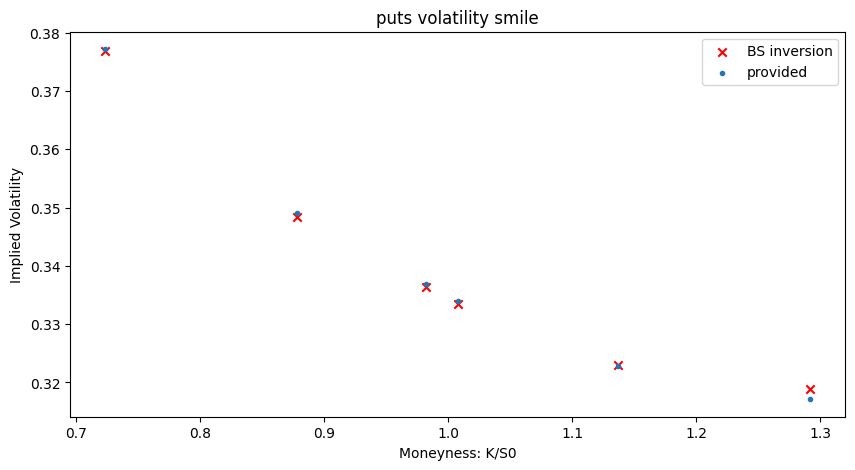

In [11]:
# Plot market implied volatilities w.r.t. log moneyness
x = (puts_strikes/S0)
# IV_filtered = [iv for iv in IV_market_p if iv != -1]
# x_filtered = [log_m for iv, log_m in zip(IV_market_p, x) if iv != -1]
IV_filtered = [iv for iv in IV_market if iv != -1]
x_filtered = [log_m for iv, log_m in zip(IV_market, x) if iv != -1]

fig, ax1 = plt.subplots(figsize=(10,5))

#puts
ax1.scatter(x, IV_market, marker='x', label='BS inversion', color='red')
ax1.scatter(x, puts['P_IV'], marker='.', label='provided')

ax1.set_xlabel('Moneyness: K/S0'); ax1.set_ylabel('Implied Volatility'); ax1.set_title('puts volatility smile')

ax1.legend(); plt.show()


In [13]:
otko_aapl = pd.read_csv('../../data/AAPL/aapl_otko_1year.csv')

th_prices = pd.DataFrame({
    'K1': otko_aapl['K1'],
    'K2': otko_aapl['K2'],
    'Midpoint (%)': otko_aapl['Midpoint(%)']
})
print(otko_aapl)
th_mc_prices = pd.DataFrame({})
th_cf_prices = pd.DataFrame({})

otko_strikes = otko_aapl[['K1', 'K2']].values / 100
otko_spreads =  otko_aapl['ASK(%)'] - otko_aapl['BID(%)']
otko_weights = 1/otko_spreads**2
otko_mkt_prices = otko_aapl['Midpoint(%)'].values

  Starting date Stock Name Expiry  K1  K2  BID(%)  Midpoint(%)  ASK(%)
0    20/01/2016        SPX     1Y  75   0    1.33         1.45    1.57
1    20/01/2016        SPX     1Y  70   0    0.63         0.71    0.78
2    20/01/2016        SPX     1Y  85  75    2.67         2.90    3.14
3    20/01/2016        SPX     1Y  80  70    1.88         2.04    2.20
4    20/01/2016        SPX     1Y  90  80    3.76         4.00    4.23


### Option pricing calibration on the full set of options

#### Merton Jump Diffusion model

In [15]:
x0 = mert_params     # initial guess: [σ, λ, m, v]
bounds = ( [1e-3, 0, -2, 0], [2, 10, 5, 10] )

def cost_function(x, p_strikes, p_mkt_prices, o_strikes, o_mkt_prices):
    sigma, lambd, meanJ, stdJ = x
    M = Merton_pricer(S0, None, T, r, q, sigma, lambd, meanJ, stdJ, 'put')
    sq_err = np.sum( weights*(M.closed_formula_put(p_strikes) - p_mkt_prices)**2)
    for k in range(len(o_strikes)):
        sq_err +=  otko_weights[k]*(M.closed_formula_otko(o_strikes[k][0], o_strikes[k][1]) - o_mkt_prices[k])**2
    return sq_err

start = time.time()
mert = scpo.least_squares(cost_function, x0, args=(puts_strikes, puts_prices, otko_strikes, otko_mkt_prices), bounds=bounds, method = 'trf', verbose=2)
end = time.time()

mert_params_calibrated = [round(p,4) for p in mert.x[:4]]

   Iteration     Total nfev        Cost      Cost reduction    Step norm     Optimality   
       0              1         5.8250e+04                                    4.89e+06    
       1              5         5.7414e+04      8.35e+02       3.54e-03       1.18e+06    
       2              6         5.7166e+04      2.48e+02       5.99e-04       6.24e+05    
       3              7         5.7068e+04      9.88e+01       1.19e-03       8.62e+05    
       4              9         5.7010e+04      5.77e+01       4.10e-04       2.51e+05    
       5             10         5.6974e+04      3.64e+01       2.86e-04       2.38e+05    
       6             11         5.6899e+04      7.43e+01       5.60e-04       2.47e+05    
       7             12         5.6752e+04      1.47e+02       1.12e-03       2.30e+05    
       8             13         5.6569e+04      1.84e+02       2.25e-03       1.30e+06    
       9             15         5.6456e+04      1.13e+02       8.46e-04       2.27e+05    

In [16]:
print('\nMETHOD: LEAST SQUARES (trf)')
print(f'> Calibrated Volatlity [σ] = {mert_params_calibrated[0]} \t {round(mert_params_calibrated[0]*100,2)}%')
print('> Calibrated Jump intensity [λ] = ', round(mert_params_calibrated[1],2))
print('> Calibrated Jump Mean = ', round(mert_params_calibrated[2],3))
print('> Calibrated Jump St. dev.  = ', round(mert_params_calibrated[3],3))
print(f'TIME ELAPSED:  {round(end-start,2)} sec')


METHOD: LEAST SQUARES (trf)
> Calibrated Volatlity [σ] = 0.3436 	 34.36%
> Calibrated Jump intensity [λ] =  2.58
> Calibrated Jump Mean =  0.092
> Calibrated Jump St. dev.  =  0.053
TIME ELAPSED:  124.24 sec


In [17]:
print(mert_params_calibrated)

[0.3436, 2.585, 0.0919, 0.053]


#### Kou Jump Diffusion Model

In [18]:
x0 = kou_params     # initial guess: [σ, λ, p, η_1, η_2]
# x0 =[0.1447, 0.9, 0.7, 2.5685, 7.75]
bounds = ( [1e-3, 1e-2, 0, 0, 0], [1, 5, 0.9,  15, 20] )

# Define the objective function
def cost_function(x, p_strikes, p_mkt_prices, o_strikes, o_mkt_prices):
    sigm, lamb, p, eta1, eta2 = x
    KOU = Kou_pricer(S0=S0, K=p_strikes, ttm=T, r=r, sigma=sigm, lambd=lamb, p=p, eta1=eta1, eta2=eta2, exercise=exercise)
    sq_err = np.sum(weights*(KOU.closed_formula_put(p_strikes) - p_mkt_prices) ** 2)
    for k in range(len(o_strikes)):
        sq_err += otko_weights[k]*(KOU.closed_formula_otko(o_strikes[k][0], o_strikes[k][1]) - o_mkt_prices[k]) ** 2
    return sq_err

start2=time.time()
kou = scpo.least_squares(cost_function, x0, args=(puts_strikes, puts_prices, otko_strikes, otko_mkt_prices),  method='trf', bounds=bounds, verbose=2)
end2 =time.time()

   Iteration     Total nfev        Cost      Cost reduction    Step norm     Optimality   
       0              1         1.7004e+04                                    1.33e+05    
       1              5         1.6723e+04      2.81e+02       2.40e-03       4.48e+04    
       2              6         1.6715e+04      8.37e+00       3.13e-03       2.59e+04    
       3              7         1.6688e+04      2.68e+01       5.71e-04       2.32e+04    
       4              8         1.6655e+04      3.29e+01       1.42e-03       2.92e+04    
       5              9         1.6628e+04      2.72e+01       2.42e-03       3.11e+04    
       6             10         1.6574e+04      5.45e+01       5.02e-03       2.93e+04    
       7             11         1.6469e+04      1.04e+02       9.72e-03       3.59e+04    
       8             13         1.6462e+04      7.76e+00       4.29e-03       2.51e+04    
       9             14         1.6436e+04      2.61e+01       5.81e-04       2.36e+04    

In [19]:
kou_params_calibrated = [round(p,4) for p in kou.x[:5]]

In [20]:
print('METHOD 2: Least-squares')
print(f'> Calibrated Volatlity [σ] = {round(kou_params_calibrated[0],4)} \t {round(kou_params_calibrated[0]*100,2)}%')
print('> Calibrated Jump intensity [λ] = ', round(kou_params_calibrated[1],2))
print(f'> Calibrated Upward Jump probability [p] = {round(kou_params_calibrated[2],2)}, [q] = {round(1-kou_params_calibrated[2],2)}')
print('> Calibrated Rate of Exp. 1  [η_1] = ', round(kou_params_calibrated[3],2))
print('> Calibrated Rate of Exp. 2  [η_2] = ', round(kou_params_calibrated[4],2))
print(f'TIME ELAPSED:  {round(end2-start2,2)} sec')

METHOD 2: Least-squares
> Calibrated Volatlity [σ] = 0.3058 	 30.58%
> Calibrated Jump intensity [λ] =  1.77
> Calibrated Upward Jump probability [p] = 0.16, [q] = 0.84
> Calibrated Rate of Exp. 1  [η_1] =  5.75
> Calibrated Rate of Exp. 2  [η_2] =  8.29
TIME ELAPSED:  3669.43 sec


In [21]:
print(kou_params_calibrated)

[0.3058, 1.7675, 0.1588, 5.7522, 8.2851]


#### Variance gamma model

In [22]:
x0 = vg_params
bounds = ( [1e-3, -3, 0], [1, 2, 10] )

def cost_function(x, p_strikes, p_mkt_prices, o_strikes, o_mkt_prices):
    sigma, theta, nu = x
    VG = VG_pricer(S0, None, T, r, q, sigma, theta, nu, exercise)
    prices = []
    for k in p_strikes:
        prices.append(VG.closed_formula_put(k))
    sq_err = np.sum(weights*(prices - p_mkt_prices)**2)
    for k in range(len(o_strikes)):
        sq_err += otko_weights[k]* (VG.closed_formula_otko6(o_strikes[k][0], o_strikes[k][1]) - o_mkt_prices[k]) ** 2
    return sq_err

start3=time.time()
vg = scpo.least_squares(cost_function, x0, args=(puts_strikes, puts_prices, otko_strikes, otko_mkt_prices),  method='trf', bounds=bounds, verbose=2)
end3=time.time()

vg_params_calibrated = [round(p,4) for p in vg.x[:3]]

   Iteration     Total nfev        Cost      Cost reduction    Step norm     Optimality   
       0              1         1.2960e+02                                    1.07e+04    
       1              6         1.1158e+02      1.80e+01       2.25e-03       1.24e+04    
       2              7         1.0344e+02      8.13e+00       4.43e-03       1.32e+04    
       3              8         9.5698e+01      7.74e+00       6.18e-03       1.11e+04    
       4              9         8.2738e+01      1.30e+01       1.20e-02       9.71e+03    
       5             10         7.2127e+01      1.06e+01       2.37e-02       5.96e+03    
       6             12         6.2726e+01      9.40e+00       1.81e-03       5.46e+03    
       7             13         5.9573e+01      3.15e+00       4.73e-03       6.14e+03    
       8             14         5.6254e+01      3.32e+00       5.14e-03       4.59e+03    
       9             15         5.3699e+01      2.55e+00       4.50e-03       5.39e+03    

In [23]:
print('METHOD: LEAST-SQUARES (trf)')
print(f'> Calibrated Volatility [σ] = {vg_params_calibrated[0]}, \t {round(vg_params_calibrated[0]*100,2)}%')
print('> Calibrated mean rate gamma process [θ] = ', vg_params_calibrated[1])
print('> Calibrated variance rate gamma process [v]= ', vg_params_calibrated[2])
print(f'TIME ELAPSED:  {round(end3-start3,2)} sec')

METHOD: LEAST-SQUARES (trf)
> Calibrated Volatility [σ] = 0.4036, 	 40.36%
> Calibrated mean rate gamma process [θ] =  0.0701
> Calibrated variance rate gamma process [v]=  0.4933
TIME ELAPSED:  111.86 sec


In [24]:
print(vg_params_calibrated)

[0.4036, 0.0701, 0.4933]


### RESULTS FROM CALIBRATION
This section aims to reprice the options used for calibration. On this purpose, both calls and otko prices obtained by each model are compared to the original market prices, starting point of our calibration process.


In [25]:
days = 252
paths = 5000
#CALLS PRICES
puts_calib_prices = pd.DataFrame({
    'STRIKE': puts['STRIKE'],    # array of K for call options
    'MKT_BID': puts['P_BID'],
    'MKT_MID': puts['P_Midpoint'],
    'MKT_ASK': puts['P_ASK'],

})
print(f'MARKET PRICES. STARTING DATE = 20-01-2016. EXPIRY = 1YEAR. \n{puts_calib_prices}\n')

# OTKO PRICES
otko_calib_prices = pd.DataFrame({
    'K1': otko_aapl['K1'],
    'K2': otko_aapl['K2'],
    'MKT_BID (%)': otko_aapl['BID(%)'],
    'MKT_MID (%)': otko_aapl['Midpoint(%)'],
    'MKT_ASK (%)': otko_aapl['ASK(%)']
})
print(f'MARKET PRICES. STARTING DATE = 20-01-2016. EXPIRY = 1YEAR. \n{otko_calib_prices}')

MARKET PRICES. STARTING DATE = 20-01-2016. EXPIRY = 1YEAR. 
   STRIKE  MKT_BID  MKT_MID  MKT_ASK
0    70.0     3.30    3.350     3.40
1    85.0     7.50    7.575     7.65
2    95.0    11.90   11.970    12.04
3    97.5    13.15   13.255    13.36
4   110.0    20.75   20.870    20.99
5   125.0    32.06   32.230    32.40

MARKET PRICES. STARTING DATE = 20-01-2016. EXPIRY = 1YEAR. 
   K1  K2  MKT_BID (%)  MKT_MID (%)  MKT_ASK (%)
0  75   0         1.33         1.45         1.57
1  70   0         0.63         0.71         0.78
2  85  75         2.67         2.90         3.14
3  80  70         1.88         2.04         2.20
4  90  80         3.76         4.00         4.23


#### Merton Jump Diffusion

CALIBRATED PARAMETERS [σ		λ		m		v]
> European puts:	 [0.0983, 2.5653, 0.2151, 0.0562]
> OTKO DC:			 [0.22, 3.0233, 0.0349, 0.2276]
> puts + OTKO:		 [0.3436, 2.585, 0.0919, 0.053]


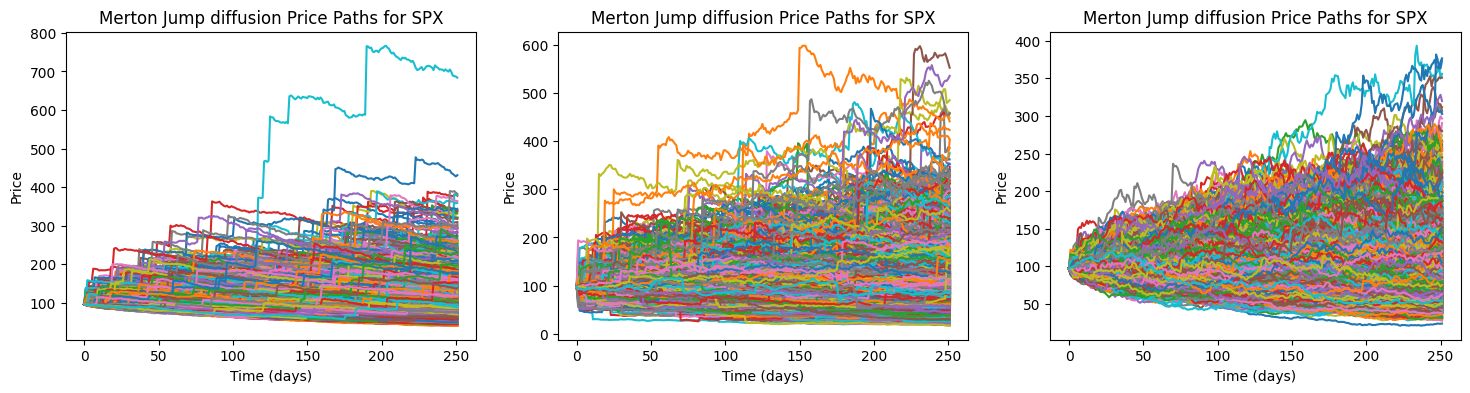

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

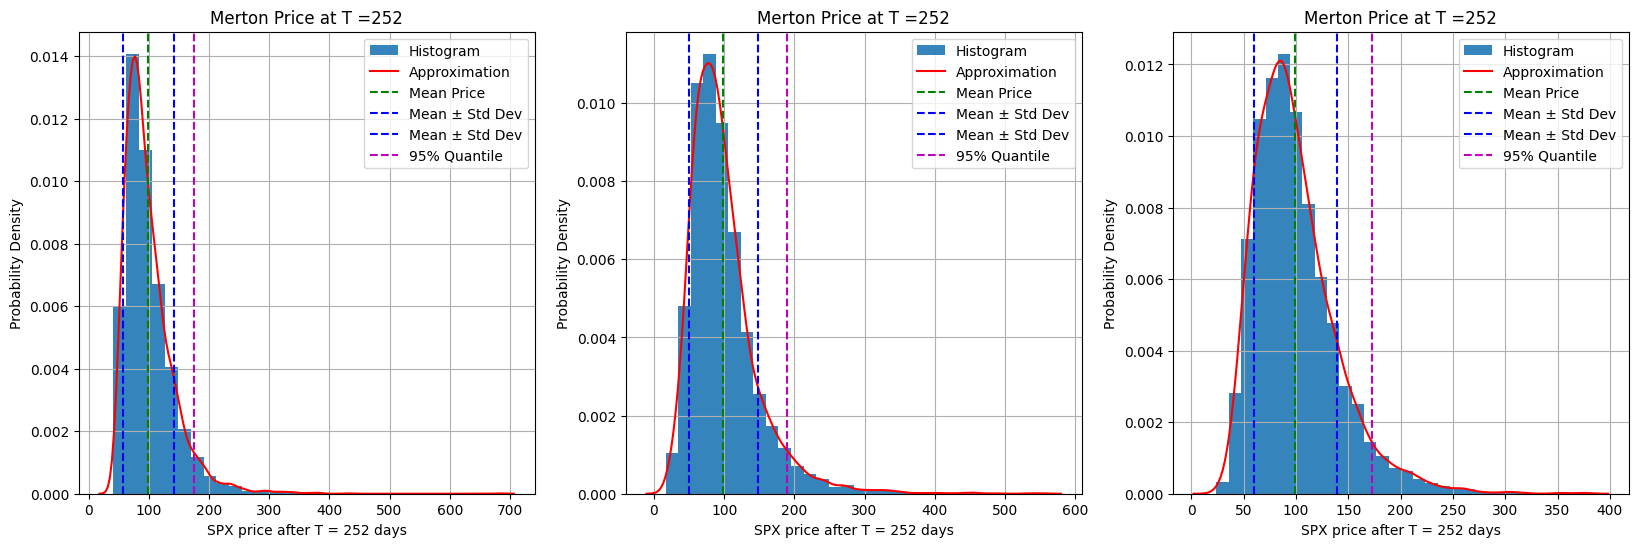

In [26]:
m_params_puts = [0.0983, 2.5653, 0.2151, 0.0562]
m_params_otko = [0.22, 3.0233, 0.0349, 0.2276]
m_params_mixed = mert_params_calibrated

print(f'CALIBRATED PARAMETERS [σ\t\tλ\t\tm\t\tv]')
print(f'> European puts:\t {m_params_puts}')
print(f'> OTKO DC:\t\t\t {m_params_otko}')
print(f'> puts + OTKO:\t\t {m_params_mixed}')

Merton1 = Merton_pricer(S0, None, T, r, q, m_params_puts[0], m_params_puts[1], m_params_puts[2], m_params_puts[3], exercise)
Merton2 = Merton_pricer(S0, None, T, r, q, m_params_otko[0], m_params_otko[1], m_params_otko[2], m_params_otko[3], exercise)
Merton3 = Merton_pricer(S0, None, T, r, q, m_params_mixed[0], m_params_mixed[1], m_params_mixed[2], m_params_mixed[3], exercise)

SMerton1 = Merton1.MertonPath(days, paths)
SMerton2 = Merton2.MertonPath(days, paths)
SMerton3 = Merton3.MertonPath(days, paths)

# PLOT MONTE CARLO PATHS
fig1, axes = plt.subplots(nrows=1, ncols=3, figsize=(18,4))
Merton1.plotMertonPath(SMerton1, 'SPX', ax=axes[0])
Merton2.plotMertonPath(SMerton2, 'SPX', ax=axes[1])
Merton3.plotMertonPath(SMerton3, 'SPX', ax=axes[2])
plt.show()

# PLOT FINAL PRICE DISTRIBUTIONS
fig2, axes = plt.subplots(nrows=1, ncols=3, figsize=(20, 6))
Merton1.plotMertonAtFixedTime(SMerton1, 251, 'SPX', ax = axes[0])
Merton2.plotMertonAtFixedTime(SMerton2, 251, 'SPX', ax = axes[1])
Merton3.plotMertonAtFixedTime(SMerton3, 251, 'SPX', ax = axes[2])

Then we show our options priced by the Merton model, using the parameters calibrated on the full set of European puts and One Touch Knockout Daily Cliquets.

In [28]:
avg_payoffs = []
for k in puts_strikes:
    payoffs = []        # stores here the payoff for each path, for a specific couple K1-K2
    for St in SMerton3[-1]:
        payoffs.append(Merton3.payoff_put(k, St))
    avg_payoffs.append(np.mean(payoffs))

merton_mc_prices = np.zeros(len(puts_calib_prices))
merton_cf_prices = np.zeros(len(puts_calib_prices))

for index in range(len(puts_calib_prices)):
    merton_mc_prices[index] = np.exp(-r*T)* avg_payoffs[index]
    merton_cf_prices[index] = Merton3.closed_formula_put(puts_strikes[index])

puts_calib_prices['MERTON MC (%)'] = merton_mc_prices
puts_calib_prices['MERTON CF (%)'] = merton_cf_prices

avg_payoffs = []
for K1, K2 in otko_strikes:
    payoffs = []        # stores here the payoff for each path, for a specific couple K1-K2
    for path in SMerton3.T:
        payoffs.append(Merton3.payoff_otko(path, K1, K2))
    avg_payoffs.append(np.mean(payoffs))

merton_mc_prices = np.zeros(len(otko_calib_prices))
merton_cf_prices = np.zeros(len(otko_calib_prices))

for index in range(len(otko_calib_prices)):
    merton_mc_prices[index] = np.exp(-r*T)* avg_payoffs[index] * 100
    merton_cf_prices[index] = Merton3.closed_formula_otko(otko_strikes[index][0], otko_strikes[index][1])

otko_calib_prices['MERTON MC (%)'] = merton_mc_prices
otko_calib_prices['MERTON CF (%)'] = merton_cf_prices

print(puts_calib_prices)
print('\n')
print(otko_calib_prices)

   STRIKE  MKT_BID  MKT_MID  MKT_ASK  MERTON MC (%)  MERTON CF (%)
0    70.0     3.30    3.350     3.40       2.885513       2.923669
1    85.0     7.50    7.575     7.65       7.524154       7.646578
2    95.0    11.90   11.970    12.04      12.113517      12.251416
3    97.5    13.15   13.255    13.36      13.438773      13.573199
4   110.0    20.75   20.870    20.99      21.007937      21.091662
5   125.0    32.06   32.230    32.40      31.775214      31.775625


   K1  K2  MKT_BID (%)  MKT_MID (%)  MKT_ASK (%)  MERTON MC (%)  MERTON CF (%)
0  75   0         1.33         1.45         1.57         0.0000   5.383723e-13
1  70   0         0.63         0.71         0.78         0.0000   1.399767e-17
2  85  75         2.67         2.90         3.14         0.0000   1.738512e-06
3  80  70         1.88         2.04         2.20         0.0000   2.377282e-09
4  90  80         3.76         4.00         4.23         0.0015   2.839281e-04


### Kou Jump Diffusion

CALIBRATED PARAMETERS: [σ		λ		p		η1		η2]
> European puts:	 [0.3414, 0.7704, 0.387, 5.4276, 9.9265]
> OTKO DC:			 [0.24, 4.7211, 0.1019, 12.5, 6.5905]
> puts + OTKO:		 [0.3058, 1.7675, 0.1588, 5.7522, 8.2851]


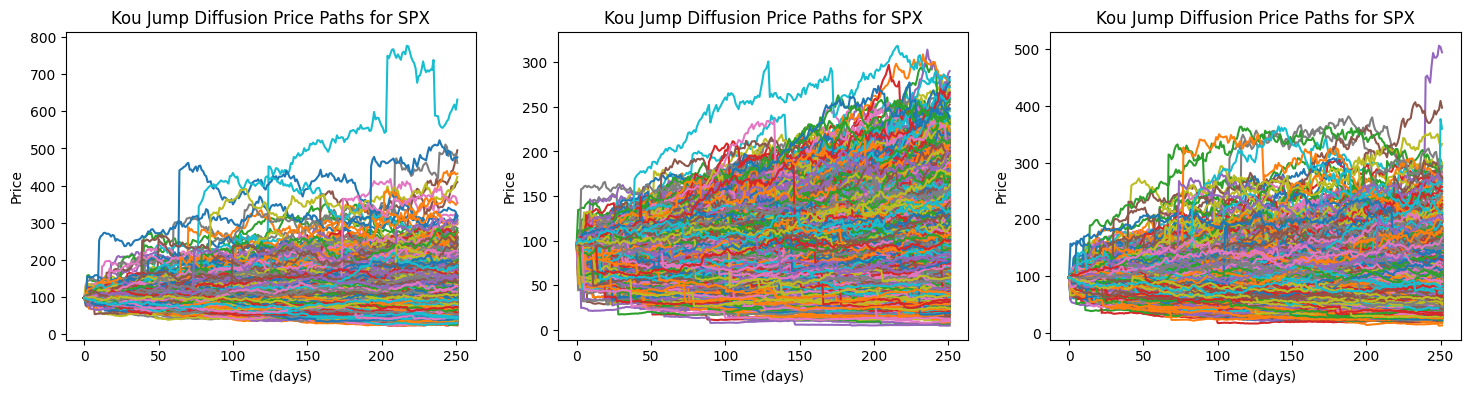

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

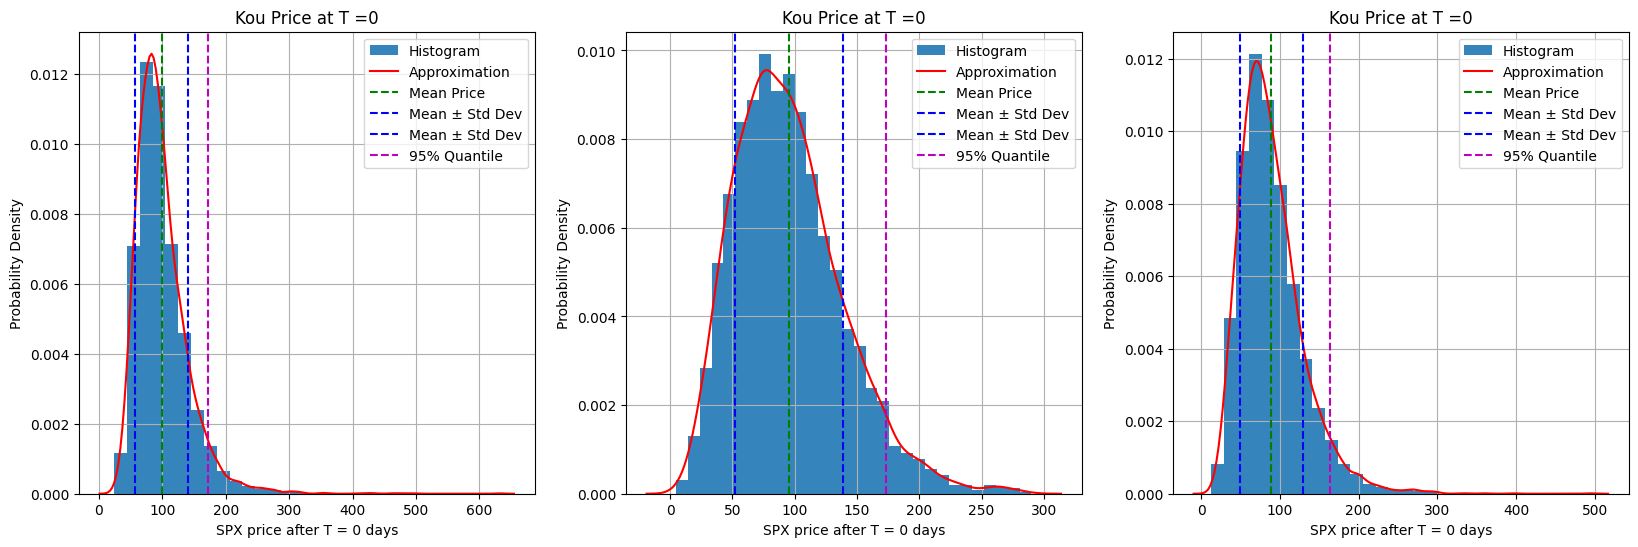

In [29]:
k_params_vanilla = [0.3414, 0.7704, 0.387, 5.4276, 9.9265]
k_params_otko = [0.24, 4.7211, 0.1019, 12.5, 6.5905]
k_params_mixed = kou_params_calibrated

print(f'CALIBRATED PARAMETERS: [σ\t\tλ\t\tp\t\tη1\t\tη2]')
print(f'> European puts:\t {k_params_vanilla}')
print(f'> OTKO DC:\t\t\t {k_params_otko}')
print(f'> puts + OTKO:\t\t {k_params_mixed}')

Kou1 = Kou_pricer(S0, None, T, r, k_params_vanilla[0], k_params_vanilla[1], k_params_vanilla[2], k_params_vanilla[3], k_params_vanilla[4], exercise)
Kou2 = Kou_pricer(S0, None, T, r, k_params_otko[0], k_params_otko[1], k_params_otko[2], k_params_otko[3], k_params_otko[4], exercise)
Kou3 = Kou_pricer(S0, None, T, r, k_params_mixed[0], k_params_mixed[1], k_params_mixed[2], k_params_mixed[3], k_params_mixed[4], exercise)

SKou1 = Kou1.KouPath(days, paths)
SKou2 = Kou2.KouPath(days, paths)
SKou3 = Kou3.KouPath(days, paths)

# PLOT MONTE CARLO PATHS
fig1, axes = plt.subplots(nrows=1, ncols=3, figsize=(18,4))
Kou1.plotKouPath(SKou1, 'SPX', ax=axes[0])
Kou2.plotKouPath(SKou2, 'SPX', ax=axes[1])
Kou3.plotKouPath(SKou3, 'SPX', ax=axes[2])
plt.show()

# PLOT FINAL PRICE DISTRIBUTIONS
fig2, axes = plt.subplots(nrows=1, ncols=3, figsize=(20, 6))
Kou1.plotKouAtFixedTime(SKou1, -1, 'SPX', ax = axes[0])
Kou2.plotKouAtFixedTime(SKou2, -1, 'SPX', ax = axes[1])
Kou3.plotKouAtFixedTime(SKou3, -1, 'SPX', ax = axes[2])

Compute the otko final prices for Kou model

In [30]:
avg_payoffs = []
for k in puts_strikes:
    payoffs = []        # stores here the payoff for each path, for a specific couple K1-K2
    for St in SKou3[-1]:
        payoffs.append(Kou3.payoff_put(k, St))
    avg_payoffs.append(np.mean(payoffs))

kou_mc_prices = np.zeros(len(puts_calib_prices))
kou_cf_prices = np.zeros(len(puts_calib_prices))

for index in range(len(puts_calib_prices)):
    kou_mc_prices[index] = np.exp(-r*T)* avg_payoffs[index]
    kou_cf_prices[index] = Kou3.closed_formula_put(puts_strikes[index])

puts_calib_prices['KOU MC (%)'] = kou_mc_prices
puts_calib_prices['KOU CF (%)'] = kou_cf_prices

avg_payoffs = []
for K1, K2 in otko_strikes:
    payoffs = []        # stores here the payoff for each path, for a specific couple K1-K2
    for path in SKou3.T:
        payoffs.append(Kou3.payoff_otko(path, K1, K2))
    avg_payoffs.append(np.mean(payoffs))

kou_mc_prices = np.zeros(len(otko_calib_prices))
kou_cf_prices = np.zeros(len(otko_calib_prices))

for index in range(len(otko_calib_prices)):
    kou_mc_prices[index] = np.exp(-r*T)* avg_payoffs[index] * 100
    kou_cf_prices[index] = Kou3.closed_formula_otko(otko_strikes[index][0], otko_strikes[index][1])

otko_calib_prices['KOU MC (%)'] = kou_mc_prices
otko_calib_prices['KOU CF (%)'] = kou_cf_prices

In [31]:
selection1 = [0,1,2,3,4,6,7]
print(f'>> PUTS\n{puts_calib_prices.iloc[:, selection1]}')
selection2 = [0,1,2,3,4,7,8]
print(f'\n>> OTKO\n{otko_calib_prices.iloc[:, selection2]}')

>> PUTS
   STRIKE  MKT_BID  MKT_MID  MKT_ASK  MERTON MC (%)  KOU MC (%)  KOU CF (%)
0    70.0     3.30    3.350     3.40       2.885513    5.888915    3.099667
1    85.0     7.50    7.575     7.65       7.524154   12.351450    7.664110
2    95.0    11.90   11.970    12.04      12.113517   17.997746   12.153159
3    97.5    13.15   13.255    13.36      13.438773   19.559044   13.450465
4   110.0    20.75   20.870    20.99      21.007937   28.129285   20.888363
5   125.0    32.06   32.230    32.40      31.775214   39.823830   31.568505

>> OTKO
   K1  K2  MKT_BID (%)  MKT_MID (%)  MKT_ASK (%)  KOU MC (%)  KOU CF (%)
0  75   0         1.33         1.45         1.57    1.114384    0.581124
1  70   0         0.63         0.71         0.78    0.598200    0.307635
2  85  75         2.67         2.90         3.14    3.985356    1.266024
3  80  70         1.88         2.04         2.20    1.964027    0.748628
4  90  80         3.76         4.00         4.23    5.663570    2.074974


#### Variance Gamma model

CALIBRATED PARAMETERS: [σ 		θ		 v]
> European puts:	 [0.3938, 0.0371, 0.2901]
> OTKO DC:			 [0.474, 0.1962, 0.2993]
> puts + OTKO:		 [0.4036, 0.0701, 0.4933]
CALIBRATED PARAMETERS: [μ_p	 μ_n	v_p	v_n]
> European puts:	 [0.536, 0.499, 0.083, 0.072]
> OTKO DC:			 [0.719, 0.522, 0.155, 0.082]
> puts + OTKO:		 [0.443, 0.373, 0.097, 0.069]


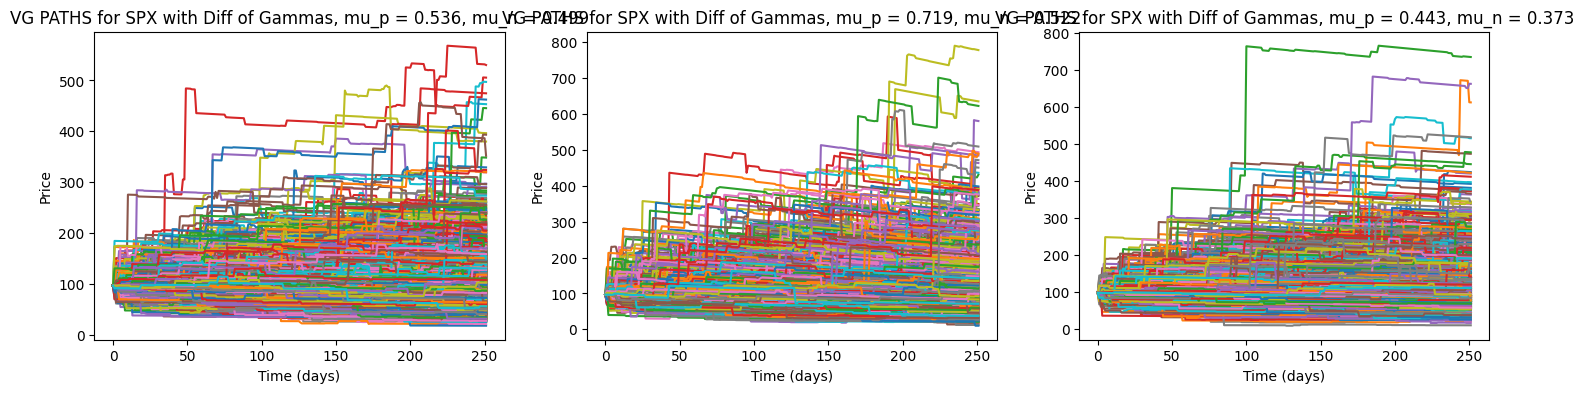

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

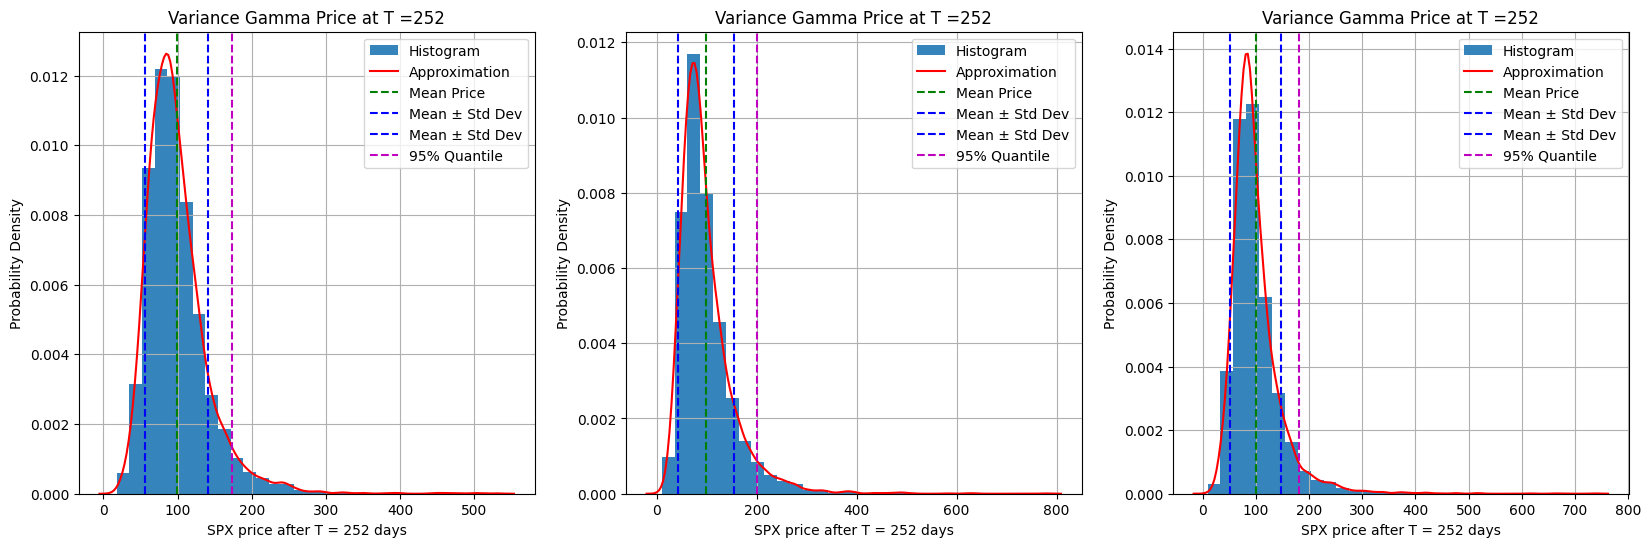

In [32]:
vg_params_puts = [0.3938, 0.0371, 0.2901]
vg_params_otko =  [0.474, 0.1962, 0.2993]
vg_params_mixed = vg_params_calibrated
# vg_params_mixed = [0.2731, 0.3931, 0.1358]

VG1 = VG_pricer(S0, None, T, r, q, vg_params_puts[0], vg_params_puts[1], vg_params_puts[2],  exercise)
VG2 = VG_pricer(S0, None, T, r, q, vg_params_otko[0], vg_params_otko[1], vg_params_otko[2], exercise)
VG3 = VG_pricer(S0, None, T, r, q, vg_params_mixed[0], vg_params_mixed[1], vg_params_mixed[2], exercise)

print(f'CALIBRATED PARAMETERS: [σ \t\tθ\t\t v]')
print(f'> European puts:\t {vg_params_puts}')
print(f'> OTKO DC:\t\t\t {vg_params_otko}')
print(f'> puts + OTKO:\t\t {vg_params_mixed}')

vg_params_puts2 = [VG1.get_mu_p, VG1.get_mu_n, VG1.get_nu_p, VG1.get_nu_n]
vg_params_otko2 = [VG2.get_mu_p, VG2.get_mu_n, VG2.get_nu_p, VG2.get_nu_n]
vg_params_mixed2 = [VG3.get_mu_p, VG3.get_mu_n, VG3.get_nu_p, VG3.get_nu_n]

for i in range(len(vg_params_puts2)):
    vg_params_puts2[i] = round(vg_params_puts2[i], 3)
    vg_params_otko2[i] = round(vg_params_otko2[i], 3)
    vg_params_mixed2[i] = round(vg_params_mixed2[i], 3)

print(f'CALIBRATED PARAMETERS: [μ_p\t μ_n\tv_p\tv_n]')
print(f'> European puts:\t {vg_params_puts2}')
print(f'> OTKO DC:\t\t\t {vg_params_otko2}')
print(f'> puts + OTKO:\t\t {vg_params_mixed2}')

SVG1 = VG1.VarianceGammaPath1(days, paths)
SVG2 = VG2.VarianceGammaPath1(days, paths)
SVG3 = VG3.VarianceGammaPath1(days, paths)

# PLOT MONTE CARLO PATHS
fig1, axes = plt.subplots(nrows=1, ncols=3, figsize=(18,4))
VG1.plotVGPath(SVG1, 'SPX', method='Diff of Gammas', ax=axes[0])
VG2.plotVGPath(SVG2, 'SPX',method='Diff of Gammas', ax=axes[1])
VG3.plotVGPath(SVG3, 'SPX', method='Diff of Gammas', ax=axes[2])
plt.tight_layout()
plt.show()


# PLOT FINAL PRICE DISTRIBUTIONS
fig2, axes = plt.subplots(nrows=1, ncols=3, figsize=(20, 6))
VG1.plotVGAtFixedTime(SVG1, 251, 'SPX', ax = axes[0])
VG2.plotVGAtFixedTime(SVG2, 251, 'SPX', ax = axes[1])
VG3.plotVGAtFixedTime(SVG3, 251, 'SPX', ax = axes[2])

In [34]:
avg_payoffs = []
for k in puts_strikes:
    payoffs = []        # stores here the payoff for each path, for a specific couple K1-K2
    for St in SVG3[-1]:
        payoffs.append(VG3.payoff_put(k, St))
    avg_payoffs.append(np.mean(payoffs))

vg_mc_prices = np.zeros(len(puts_calib_prices))
vg_cf_prices = np.zeros(len(puts_calib_prices))

for index in range(len(puts_calib_prices)):
    vg_mc_prices[index] = np.exp(-r*T)* avg_payoffs[index]
    vg_cf_prices[index] = VG3.closed_formula_put(puts_strikes[index])

puts_calib_prices['VG MC (%)'] = vg_mc_prices
puts_calib_prices['VG CF (%)'] = vg_cf_prices
avg_payoffs = []

for K1, K2 in otko_strikes:
    payoffs = []        # stores here the payoff for each path, for a specific couple K1-K2
    for path in SVG3.T:
        payoffs.append(VG3.payoff_otko(path, K1, K2))
    avg_payoffs.append(np.mean(payoffs))

vg_mc_prices = np.zeros(len(otko_calib_prices))
vg_cf_prices = np.zeros(len(otko_calib_prices))

for index in range(len(otko_calib_prices)):
    vg_mc_prices[index] = np.exp(-r*T)* avg_payoffs[index] * 100
    vg_cf_prices[index] = VG3.closed_formula_otko5(otko_strikes[index][0], otko_strikes[index][1])

otko_calib_prices['VG MC (%)'] = vg_mc_prices
otko_calib_prices['VG CF (%)'] = vg_cf_prices

In [35]:
selection1 = [0,1,2,3,4,8,9]
print(f'>> CALLS\n{puts_calib_prices.iloc[:, selection1]}')
selection2 = [0,1,2,3,4,9,10]
print(f'\n>> OTKO\n{otko_calib_prices.iloc[:, selection2]}')

>> CALLS
   STRIKE  MKT_BID  MKT_MID  MKT_ASK  MERTON MC (%)  VG MC (%)  VG CF (%)
0    70.0     3.30    3.350     3.40       2.885513   2.908195   3.271004
1    85.0     7.50    7.575     7.65       7.524154   7.630664   7.628944
2    95.0    11.90   11.970    12.04      12.113517  12.583999  12.036843
3    97.5    13.15   13.255    13.36      13.438773  14.015135  13.335069
4   110.0    20.75   20.870    20.99      21.007937  22.068316  20.903397
5   125.0    32.06   32.230    32.40      31.775214  33.283879  31.849245

>> OTKO
   K1  K2  MKT_BID (%)  MKT_MID (%)  MKT_ASK (%)  VG MC (%)  VG CF (%)
0  75   0         1.33         1.45         1.57   1.363456   1.474735
1  70   0         0.63         0.71         0.78   0.779288   0.863690
2  85  75         2.67         2.90         3.14   2.525031   2.515957
3  80  70         1.88         2.04         2.20   1.577496   1.634047
4  90  80         3.76         4.00         4.23   3.677109   3.632282
